In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0,"
from pathlib import Path
import json, shutil, random
from tqdm import tqdm
from datetime import datetime
from omegaconf import OmegaConf
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt
import lovely_tensors as lt
from PIL import Image
import torch
lt.monkey_patch()

sys.path.append("../../src")
from musubi_tuner.fpack_1fmc_generate import FramePack_1fmc
from musubi_tuner.frame_pack.hunyuan_video_packed import attn_cache
from musubi_tuner.utils.preproc_utils import get_info_from_vistorybench, get_panel_layout
from musubi_tuner.utils.viz_utils import convert_result_to_df_wpose, annot_viz, draw_final_img
from musubi_tuner.utils.attn_utils import get_img_attn_map

sys.path.append("/lustre/fs1/home/yo564250/workspace/whisperer/datasets/storyviz/vistorybench")
# sys.path.append("/projects/bffz/ykwon4/vistorybench/")
from vistorybench.data_process.dataset_process.dataset_load import StoryDataset
vistory_dataset_path = Path("/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory")
vistory_dataset = StoryDataset(vistory_dataset_path)

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.
INFO:root:Xformers is installed!
INFO:root:Flash Attn is installed!
INFO:root:Sage Attn is installed!


Trying to import sageattention
Successfully imported sageattention
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/yolox-onnx/yolox_l.torchscript.pt
model_path is /lustre/fs1/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/musubi_tuner/ckpts/hr16/DWPose-TorchScript-BatchSize5/dw-ll_ucoco_384_bs5.torchscript.pt

DWPose: Using yolox_l.torchscript.pt for bbox detection and dw-ll_ucoco_384_bs5.torchscript.pt for pose estimation
DWPose: Caching TorchScript module yolox_l.torchscript.pt on ...
DWPose: Caching TorchScript module dw-ll_ucoco_384_bs5.torchscript.pt on ...


/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yo564250/conda-envs/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


In [2]:
framepack_model = FramePack_1fmc(
    lora_path = "../../outputs/training/idmask_control_lora_wrope_v2_multi/idmask_control_lora_wrope_v2_multi_2-step00003000.safetensors"
)

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Image Projection: False
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, device=cuda:0
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /lustre/fs1/home/yo564250/workspace/ComfyUI/models/diffusion_models/FramePackI2V_HY_bf16.safetensors, info=_IncompatibleKeys(missing_keys=[], unexpected_keys=['image_projection.down.bias', 'image_projection.down.weight', 'image_projection.up.bias', 'image_projection.up.weight'])
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from ../../outputs/training/idmask_control_lora_wrope_v2_multi/idmask_control_lora_wrope_v2_multi_2-step00003000.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.net

Model, VAE, Text Encoders, LoRA loaded.


In [ ]:
main_layout_path = Path("/groups/chenchen/patrick/ViStoryBench/gen_layouts_bulk/20251004_200710_v2")
prev_output_path = Path("/groups/chenchen/patrick/ViStoryBench/outputs/whisperer/v2_multi_tmp_2000/en/20251018_220036")
story_num = '16'

# shutil.copytree(prev_output_path / story_num, f"tmp/{story_num}", dirs_exist_ok=True)
pose_layout = json.loads((main_layout_path / f"story_{story_num}/pose_layout.json").read_text())

In [ ]:
vanila_shot, vanila_character_shot, _ = get_info_from_vistorybench(vistory_dataset, story_num, 1)
width, height = 1344, 768
seed = 2048

for shot_num, layout in pose_layout.items():
    panel_layout = {row['id']-1 : {
        'bbox' : list(map(lambda x: x/1000., [row['bbox']['x'], row['bbox']['y'], row['bbox']['x']+row['bbox']['w'], row['bbox']['y']+row['bbox']['h']])), 
        'body': []
    } for row in layout['boxes']}
    story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, int(shot_num))
    if len(story_shot['character_key']) == 0:
        story_shot = vanila_shot
        characters_shot = vanila_character_shot
        panel_layout = {0: {'bbox': [0.1, 0.9, 0.2, 1.0], 'body': []}}
    elif len(story_shot['character_key']) == 1:
        panel_layout = random.choice([
            {0: {'bbox': [0.35, 0.2, 0.65, 1.0], 'body': []}}, 
            {0: {'bbox': [0.2, 0.3, 0.5, 1.0], 'body': []}}, 
            {0: {'bbox': [0.7, 0.3, 1.0, 1.0], 'body': []}}, 
        ])
    else:
        panel_layout = random.choice([
            {0: {'bbox': [0.2, 0.1, 0.5, 0.9], 'body': []}, 1: {'bbox': [0.5, 0.1, 0.9, 1.0], 'body': []}},
            {0: {'bbox': [0.1, 0.3, 0.4, 0.9], 'body': []}, 1: {'bbox': [0.5, 0.2, 0.9, 1.0], 'body': []}},
        ])

    prompt = story_shot['type'] + ";" + ";".join(prompt.split(";")[:3])

    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=400, seed=seed, crop_face_detect=True, use_rembg=True,
        debug_name=f"story{story_num}_shot{shot_num}"
    )
    result_imgs[0].save(Path("tmp") / f"{story_num}/{int(shot_num)-1}_0.png")
    debug_imgs[0].save(Path("tmp") / f"{story_num}/debug/{int(shot_num)-1}_0.png")

In [10]:
shot_num = 21
layout = pose_layout[f"{shot_num}"]
width, height = 1344, 768

panel_layout = {row['id']-1 : {
    'bbox' : list(map(lambda x: x/1000., [row['bbox']['x'], row['bbox']['y'], row['bbox']['x']+row['bbox']['w'], row['bbox']['y']+row['bbox']['h']])), 
    'body': []
} for row in layout['boxes']}
# panel_layout = {0: {'bbox': [0.4, 0.2, 0.6, 0.9], 'body': []}}
# panel_layout = {0: {'bbox': [0.2, 0.4, 0.5, 1.0], 'body': []}}
panel_layout = {1: {'bbox': [0.5, 0.3, 0.8, 0.9], 'body': []}, 0: {'bbox': [0.1, 0.1, 0.5, 0.9], 'body': []}, }
print(panel_layout)

story_shot, characters_shot, prompt = get_info_from_vistorybench(vistory_dataset, story_num, shot_num)
prompt = (
    f"{story_shot['type']};"
    # "Children's story book, illustration;"
    f"{story_shot['camera']};"
    f"{story_shot['script']};"
    f"{story_shot['scene']};"
)
# prompt = story_shot['type'] + ";" + ";".join(prompt.split(";")[:3])
# story_shot = vanila_shot
# characters_shot = vanila_character_shot
# characters_shot = {
#     'Little Brown Rabbit': {'images': ['/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/01/image/Little Brown Rabbit/00_v2.jpg']}, 
#     'Big Brown Rabbit': {'images': ['/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/01/image/Big Brown Rabbit/00.jpg']}
# }

print(prompt)
print(characters_shot)

{1: {'bbox': [0.5, 0.3, 0.8, 0.9], 'body': []}, 0: {'bbox': [0.1, 0.1, 0.5, 0.9], 'body': []}}
Urban Novel;Medium shot, eye level shot;Chen Sihan’s father stands at the doorway, expression furious and urgent. Liu Qiang lies on the floor. Chen Sihan rushes to her father, expression frightened yet relieved.;Nighttime, Aunt’s upstairs room, door kicked open, Chen Sihan’s father standing in the doorway, expression furious and anxious.;
{'Chen Sihan': {'name': 'Chen Sihan', 'key': 'Chen Sihan', 'prompt': 'A modern Chinese woman with black hair and black eyes, around 25 years old, with delicate features. She dresses in fashionable urban attire and has an independent and strong personality.', 'tag': 'realistic_human', 'num_of_appearances': 19, 'images': ['/lustre/fs1/groups/chenchen/patrick/ViStoryBench/dataset/ViStory/16/image/Chen Sihan/00.jpg']}, "Chen Sihan's Father": {'name': "Chen Sihan's Father", 'key': "Chen Sihan's Father", 'prompt': 'A middle-aged man with black hair and black eyes,

  0%|          | 0/25 [00:00<?, ?it/s]

INFO:root:Activate Attention Caching for Exp.
INFO:root:1000.0: hidden_states: tensor[1, 4832, 3072] bf16 n=14843904 (28Mb) x∈[-17.625, 20.500] μ=-0.015 σ=0.871 cuda:0
INFO:root:1000.0: encoder_hidden_states: tensor[1, 75, 3072] bf16 n=230400 (0.4Mb) x∈[-1.760e+03, 498.000] μ=0.009 σ=8.562 cuda:0
INFO:root:1000.0: temb: tensor[1, 3072] bf16 6Kb x∈[-9.375, 20.000] μ=-0.111 σ=0.961 cuda:0
INFO:root:1000.0: attention_mask: tensor[1, 4907, 4907] bf16 n=24078649 (46Mb) x∈[0., 0.] μ=0. σ=0. -Inf! cuda:0
INFO:root:1000.0: rope_freqs: tensor[1, 4832, 256] n=1236992 (4.7Mb) x∈[-1.000, 1.000] μ=0.307 σ=0.637 cuda:0
INFO:root:1000.0: defaultdict(<class 'list'>, {'rope_freqs': [tensor[1, 4032, 256] n=1032192 (3.9Mb) x∈[-1.000, 1.000] μ=0.307 σ=0.637 cuda:0, tensor[1, 400, 256] n=102400 (0.4Mb) x∈[-1.000, 1.000] μ=0.340 σ=0.620 cuda:0, tensor[1, 400, 256] n=102400 (0.4Mb) x∈[-1.000, 1.000] μ=0.280 σ=0.649 cuda:0], 'clean_latents': [(0, 400), (400, 800)], 'noise': [(800, 4832)], 'text_embeddings': [

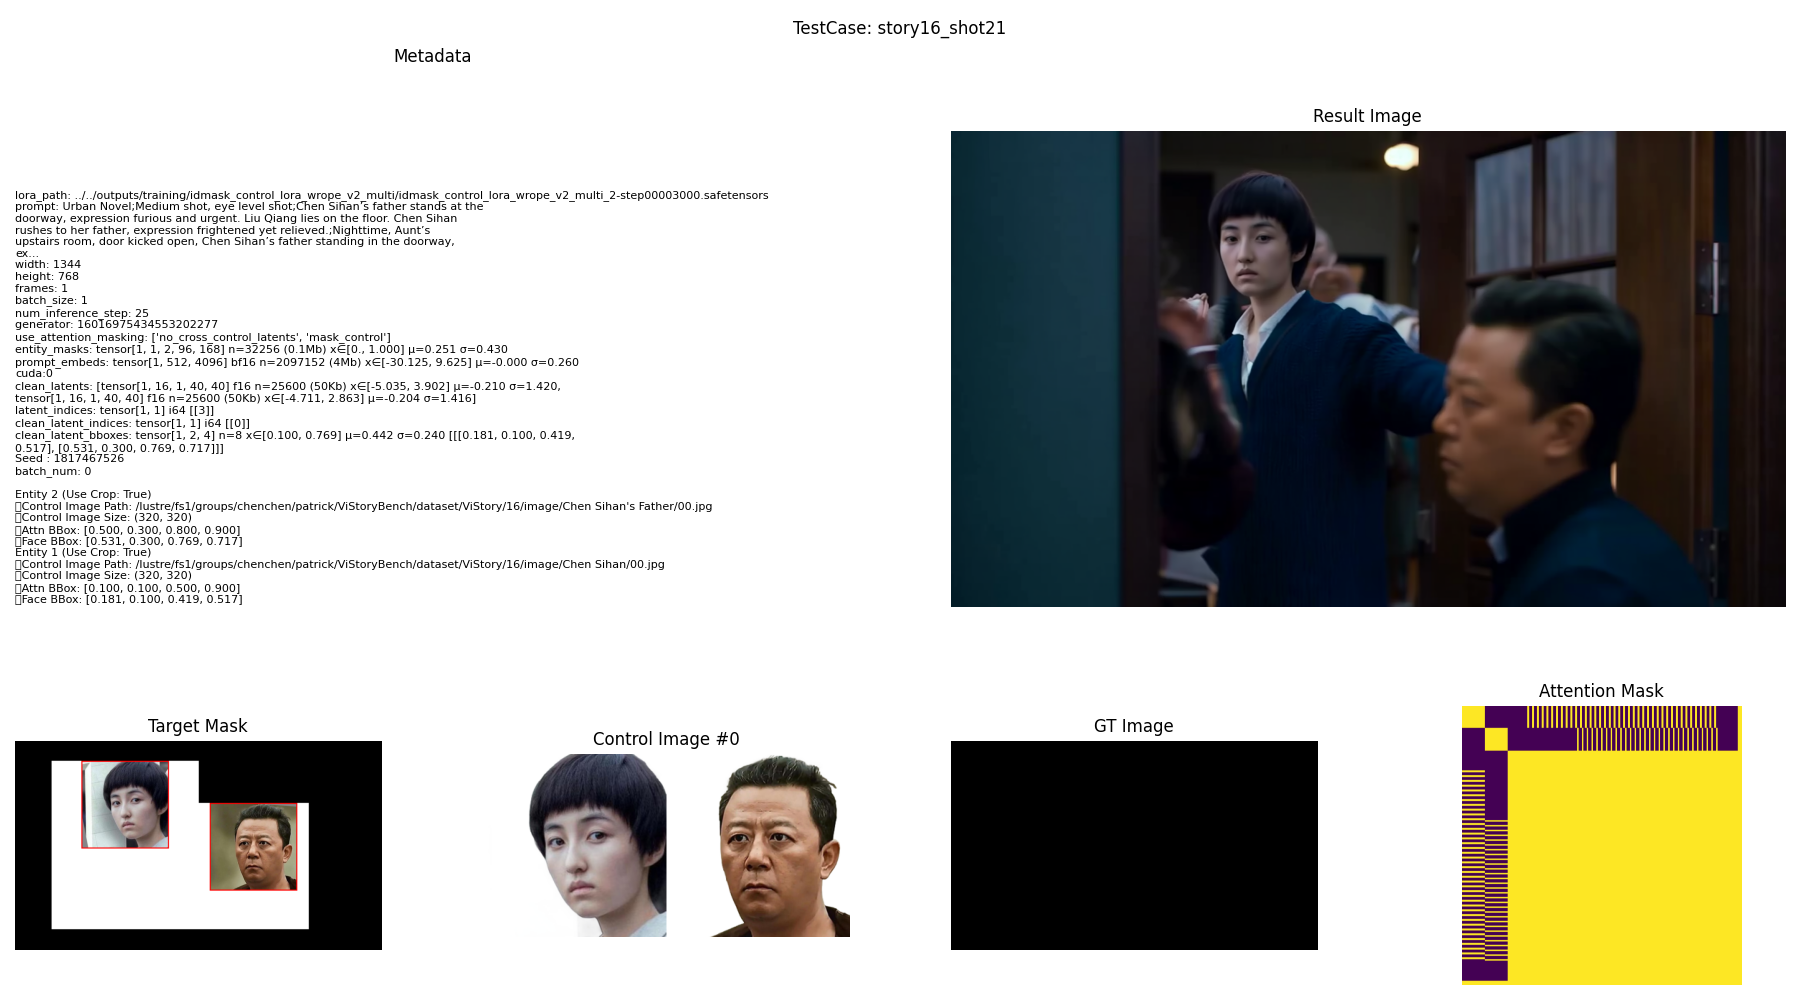

In [ ]:
seed = np.random.randint(2**31)
result_imgs, debug_imgs, debug_mask = framepack_model(
    prompt, panel_layout, characters_shot, width, height,
    c_width_given=320, seed=seed, crop_face_detect=True, use_rembg=True,
    cache_results=True, cache_layers=['transformer_blocks.2'],
    debug_name=f"story{story_num}_shot{shot_num}"
)
result_imgs[0].save(Path("tmp") / f"{story_num}/{shot_num-1}_0.png")
debug_imgs[0].save(Path("tmp") / f"{story_num}/debug/{shot_num-1}_0.png")
debug_imgs[0]

In [14]:
target_sbj=1
block_id=f'transformer_blocks.2'
t_0=3
t_1=4
normalize=True

timesteps = sorted(list(attn_cache[block_id].keys()), reverse=False)
token_H, token_W = height // 16, width // 16
clean_latent_inds = attn_cache['attn_dict']['clean_latents']
noise_inds = attn_cache['attn_dict']['noise']

timesteps = sorted(list(attn_cache[block_id].keys()), reverse=False)
attention_probs = sum(attn_cache[block_id][timesteps[t]][:,noise_inds[0][0]:noise_inds[0][1],:] for t in range(t_0, t_1))
attention_map = rearrange(attention_probs, 'B (H W) D -> B H W D', H=token_H, W=token_W)
attention_map = attention_map.permute(0,3,1,2)
attention_map = attention_map[0,clean_latent_inds[0][0]:clean_latent_inds[-1][1],:,:].mean(axis=0)

if normalize:
    attention_map -= attention_map.min(1, keepdim=True)[0]
    attention_map /= attention_map.max(1, keepdim=True)[0]
attention_map.shape
# Image.fromarray((attention_map.to(dtype=torch.float32).cpu().numpy()*255).astype(np.uint8))

torch.Size([48, 84])

In [ ]:
results_dict_temp = {}
for i in range(9):
    seed = np.random.randint(2**31)
    result_imgs, debug_imgs, debug_mask = framepack_model(
        prompt, panel_layout, characters_shot, width, height,
        c_width_given=320, seed=seed, crop_face_detect=True, use_rembg=True,
        debug_name=f"story{story_num}_shot{shot_num}"
    )

    results_dict_temp[i] = {
        'seed' : seed,
        'result_img': result_imgs[0], 'debug_img': debug_imgs[0],
        'debug_mask': debug_mask,
    }

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, (key, value) in enumerate(results_dict_temp.items()):
    ax[i // 3, i % 3].imshow(value['result_img'])
    ax[i // 3, i % 3].set_title(f"Seed {value['seed']}")
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
results_dict_temp[8]['result_img'].save(Path("tmp") / f"{story_num}/{shot_num-1}_0.png")
results_dict_temp[8]['debug_img'].save(Path("tmp") / f"{story_num}/debug/{shot_num-1}_0.png")

In [ ]:
outputs_root = Path("/groups/chenchen/patrick/ViStoryBench/outputs/")
story_num = 77
shutil.copytree(
    f"/home/yo564250/workspace/whisperer/related/framepackbase/musubi-tuner/src/practice/tmp/{story_num}", 
    outputs_root / f"whisperer/v2_multi_tmp_2000/en/20251018_220036_v2/{story_num}_v2", 
    dirs_exist_ok=True
)

In [ ]:
tmp = {
    "[PANEL-1]": {"bbox": [520, 40, 960, 380], "body" : [[180, 120, 900, 960]]},
    "[PANEL-2]": {"bbox":  [40, 40, 500, 380], "body" : [[120, 420, 880, 820]]},
    "[PANEL-3]": {"bbox": [40, 400, 960, 960], "body" : [[60, 200, 620, 980],[420, 260, 720, 880],[740, 280, 960, 860]]}
}

page_sub = convert_result_to_df_wpose(tmp, 768, 1024)
final_layout = annot_viz(Image.new("RGB", (768, 1024), (0,0,0)), page_sub, label_col='frame_id2')
final_layout